### Test case LVV-T376: Verify the Calculation of Ellipticity Residuals and Correlations

Verify that the DMS includes software to enable the calculation of the ellipticity residuals and correlation metrics defined in the OSS. 

### Test case LVV-T2176: Per-image limit on the median residual ellipticity correlations at scales greater than or equal to 5 arcmin.

Verify that the per-image limit on the median residual ellipticity correlations at scales greater than or equal to 5 arcmin (TE4) can be configured in the DMS and applied to the appropriate metrics.

### LVV-T2177: Per-image limit on the median residual ellipticity correlations at scales less than to 5 arcmin.

Verify that the per-image limit on the median residual ellipticity correlations at scales less than 5 arcmin (TE3) can be configured in the DMS and applied to the appropriate metrics.

**Discussion**: The TEx metrics are calculated and persisted per-visit, and thus reside in the `visit` table. To verify this requirement, we retrieve the measurements and perform additional calculations in the notebook. Eventually we plan to include these calculations, and related plots and metrics, in the `analysis_tools` package.

In [1]:
from lsst.daf.butler import Butler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from lsst.utils.plotting import publication_plots
publication_plots.set_rubin_plotstyle()
from matplotlib.ticker import ScalarFormatter

While the [TargetRefcatDeltaPhotomMetrics](https://github.com/lsst/analysis_tools/blob/e52006734b52f2011d899b2a94f549ff4b88daf7/python/lsst/analysis/tools/atools/refCatMatchPlots.py#L778-L855) task to calculate the offsets exists in `analysis_tools`, it is not part of the default pipelines. For this test, we ran the task on the LSSTCam data processed with w_2025_37 of the DRP pipeline. The results are retrieved from the relevant collection below.

NOTE: currently on a branch -- to be merged soon!

Code that adds it to the visit summary table: https://github.com/lsst/drp_tasks/blob/2d1432dc37d3130be2872ad98928836b8227db9d/python/lsst/drp/tasks/update_visit_summary.py#L870-L874

[PR](https://github.com/lsst/pipe_tasks/pull/1159) to add to `pipe_tasks`

[PR]() to add to `afw.image._exposureSummaryStats`


In [2]:
testcoll = 'u/leget/LSSTCam/DM-46582/PSF_TEx_w37_run2'
butler = Butler('/repo/main', collections=[testcoll])

#### Retrieve the `visit_table` from the Butler:

In [3]:
visitTable = butler.get("visit_table", instrument="LSSTCam")

The description of residual ellipticity correlation requirements in the [OSS](ls.st/oss) specifies that the requirements should be met for E_1, E_2, and E_X. The calculations for these have already been implemented, so that we must retrieve three separate columns from the `visit_table`: `psfTE3e1`, `psfTE3e2`, and `psfTE3ex`.

Note that the TE3 and TE4 metrics are thresholds on the per-image median residual ellipticity correlations. In the computeExposureSummaryTask that calculates these, TE3 and TE4 are persisted as the median for each visit.

For each of these, we plot histograms of their distributions, and overlay a vertical line denoting the threshold value.

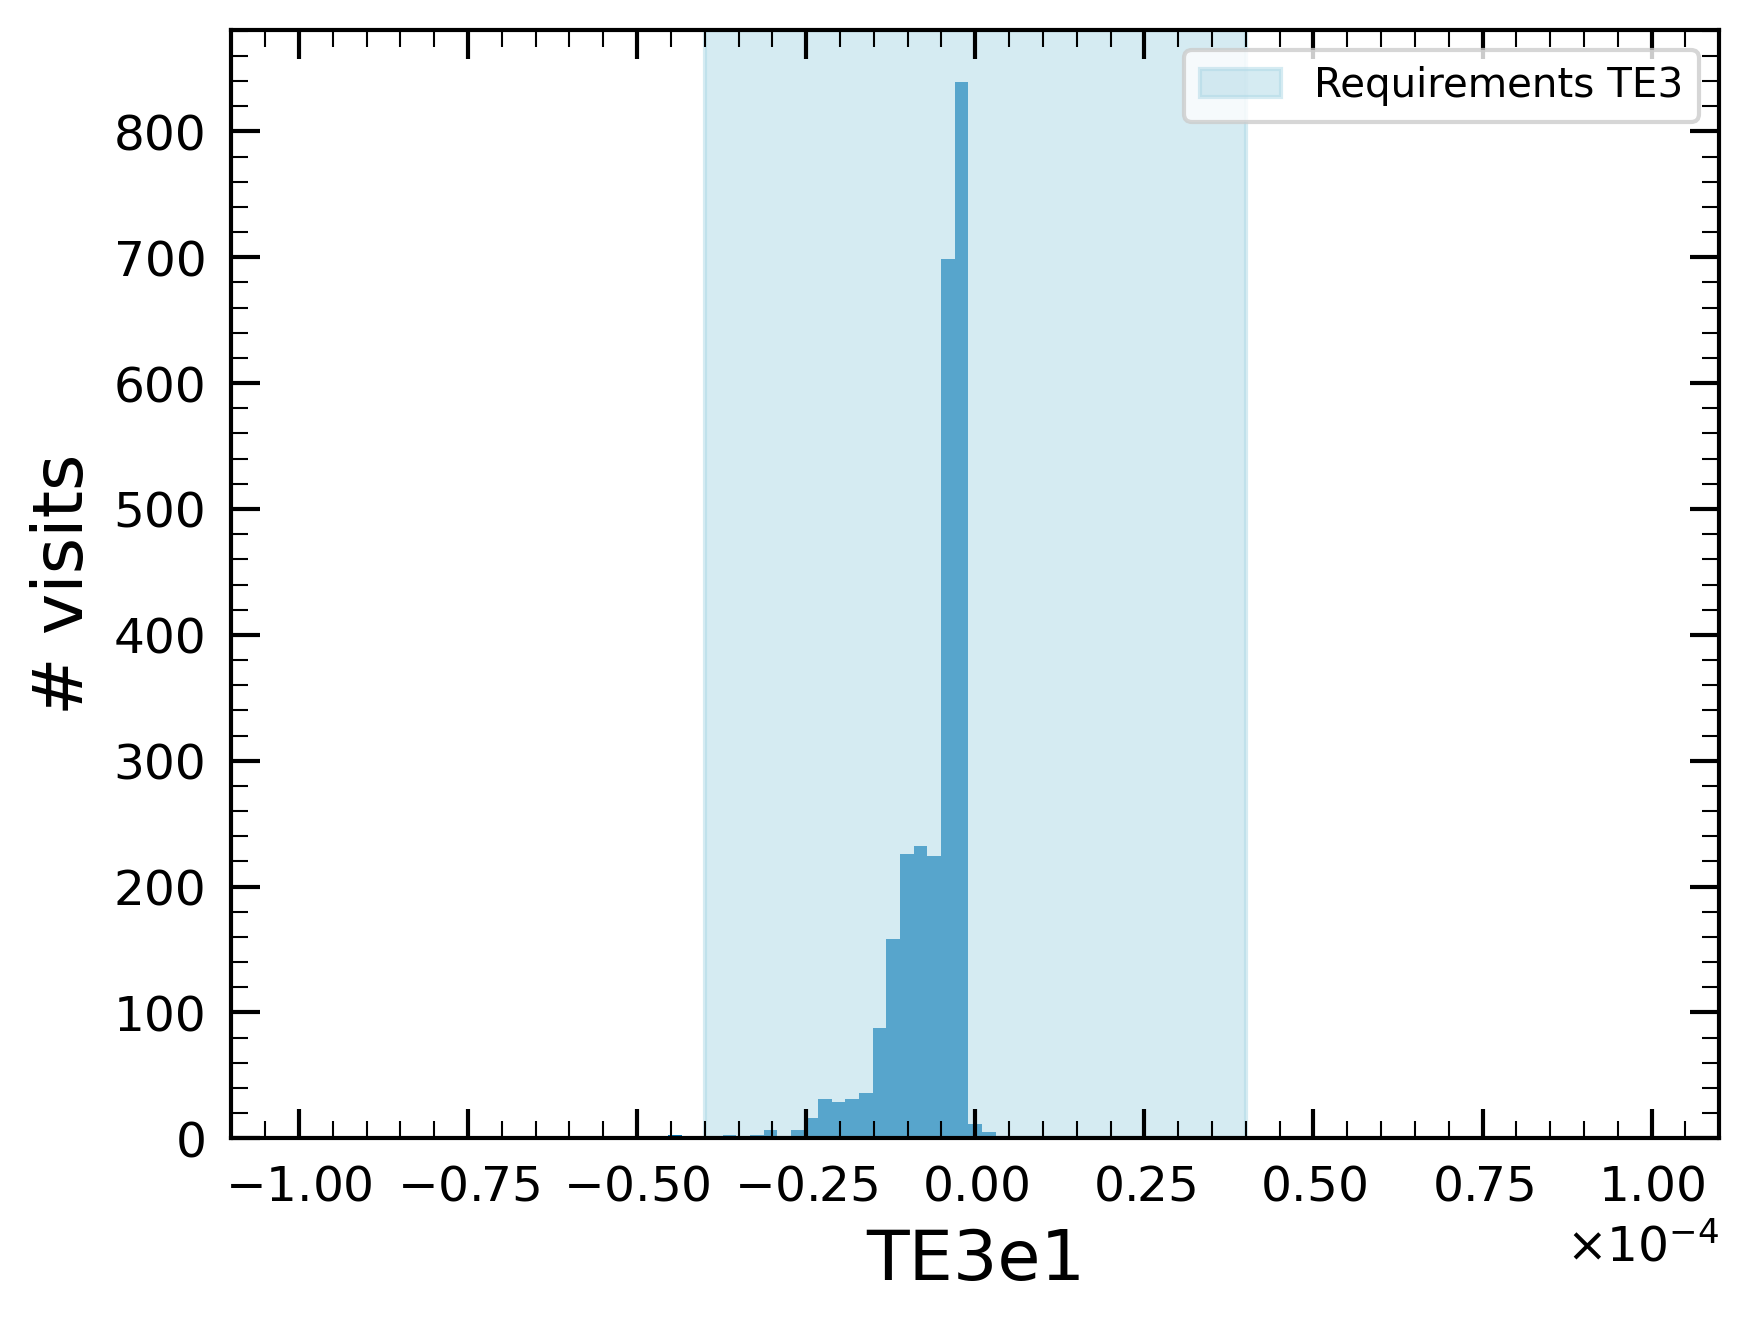

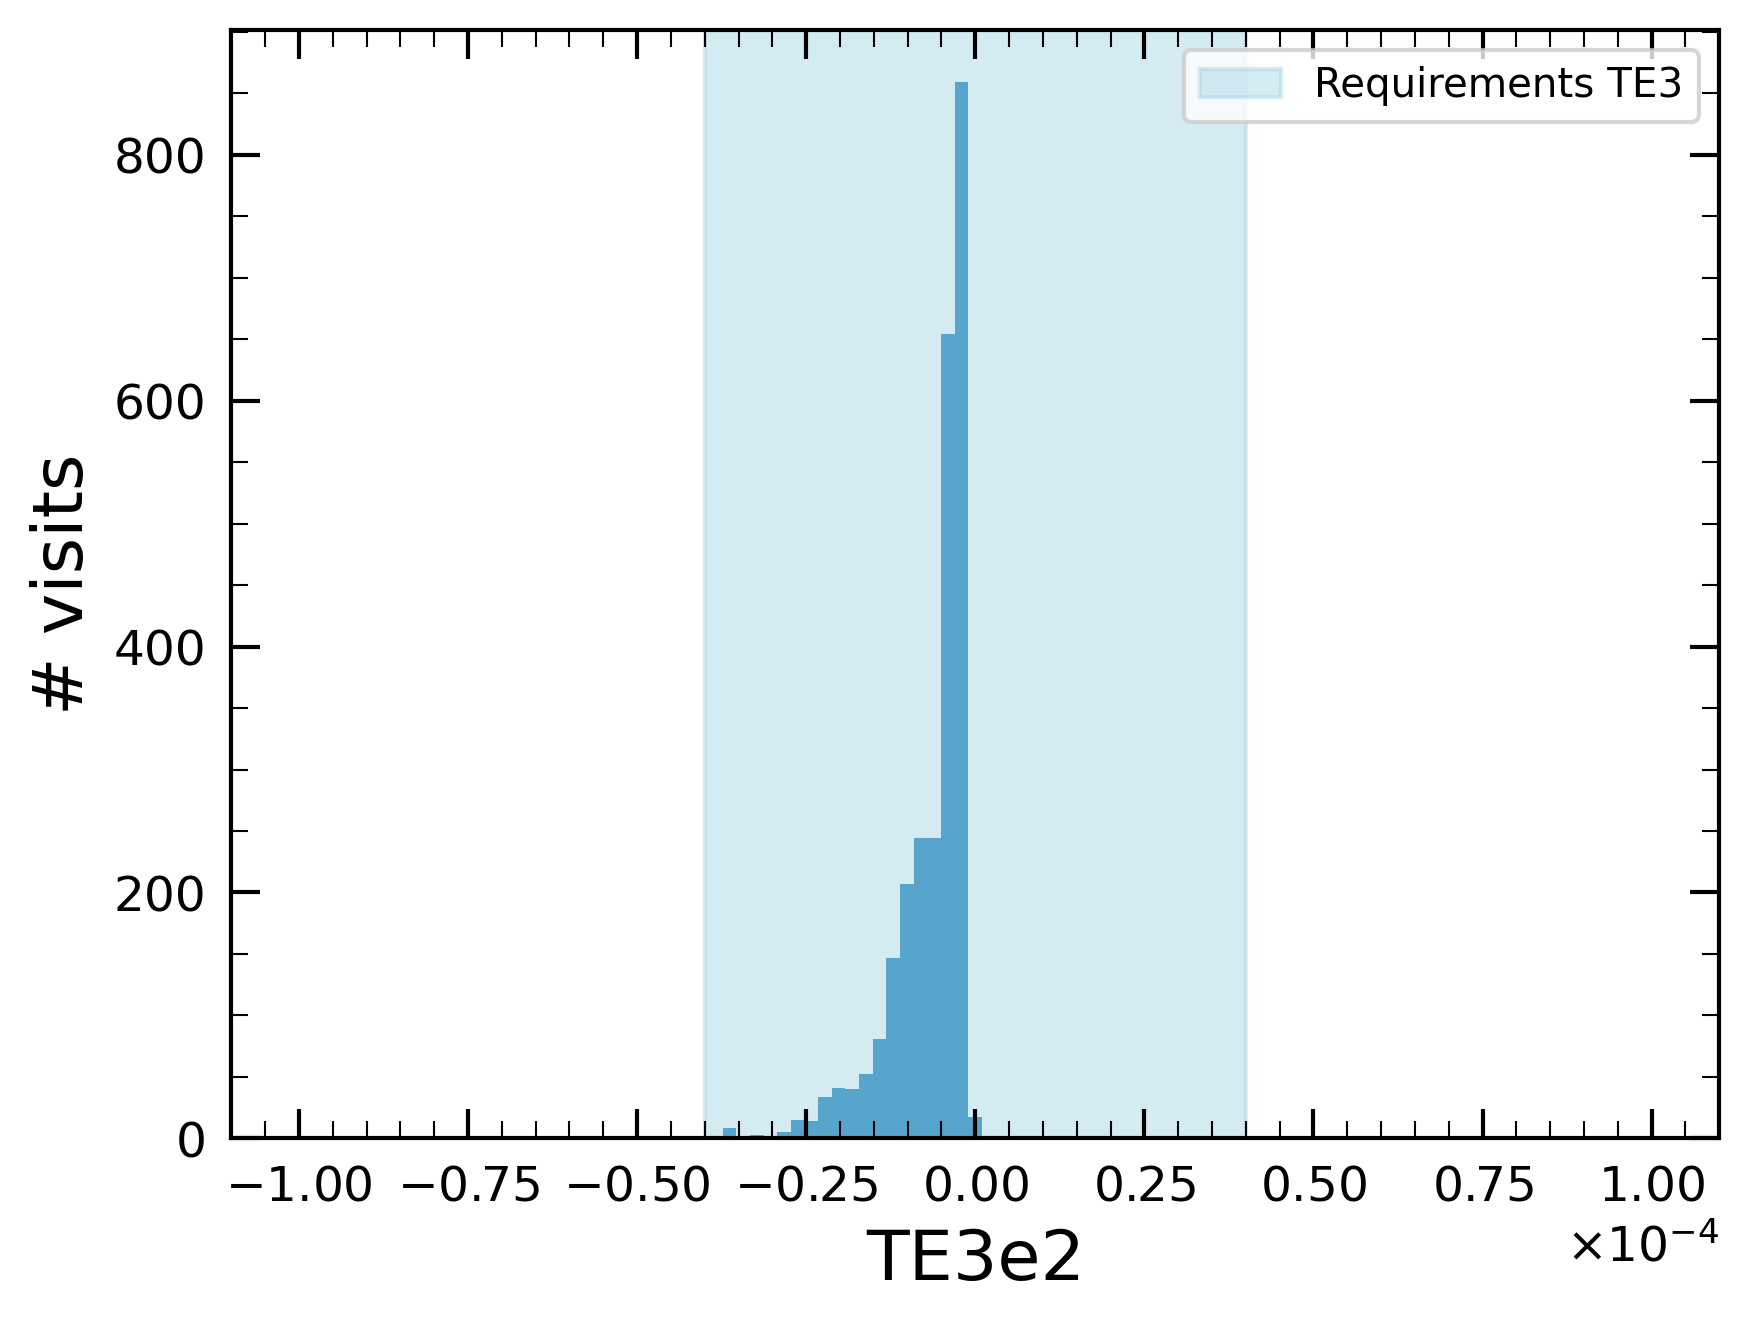

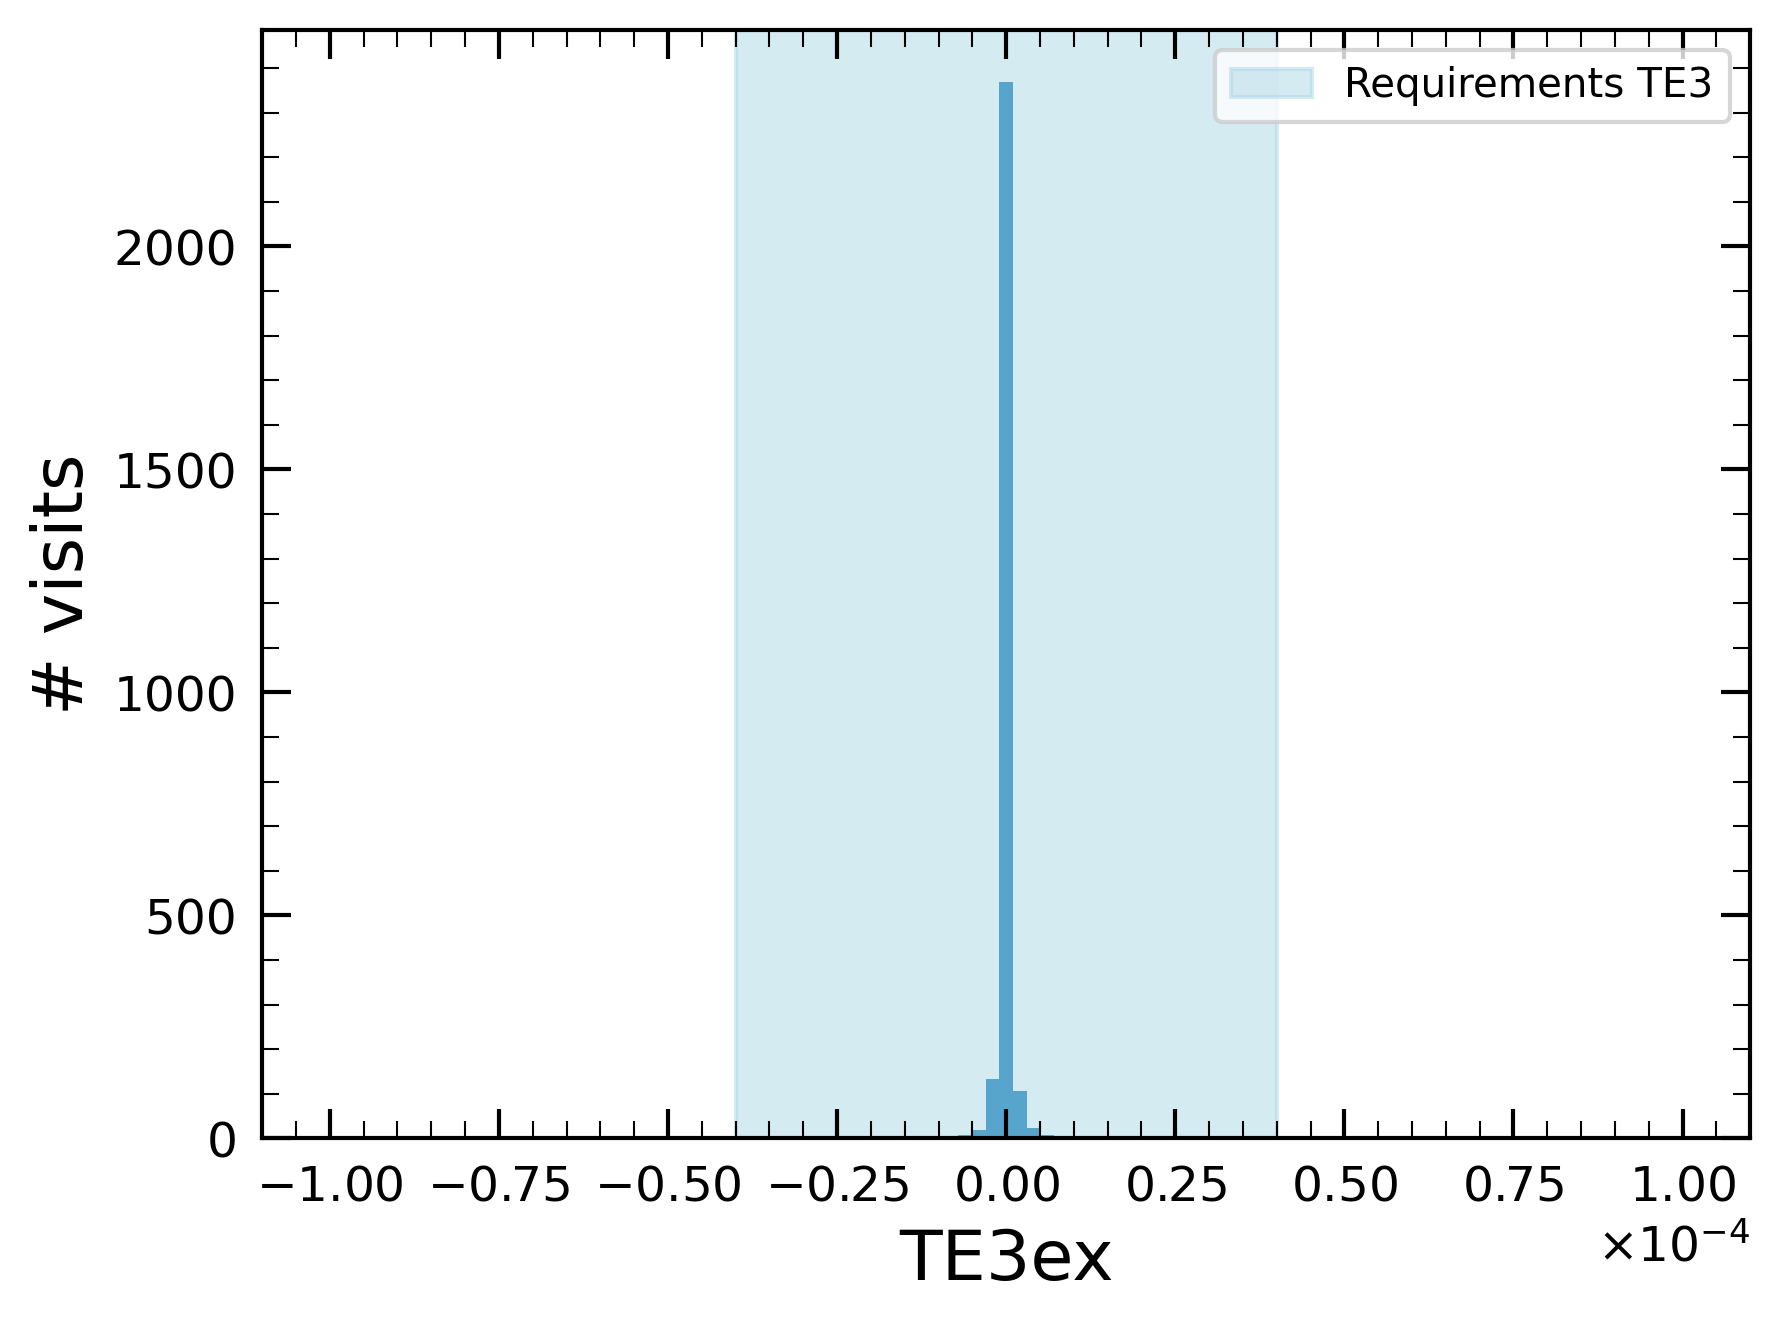

In [4]:
te3_requirement = 4e-5

for i in ['1', '2', 'x']:
    plt.figure()
    plt.hist(visitTable[f'psfTE3e{i}'], bins=np.linspace(-1e-4, 1e-4, 100))
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.xlabel(f"TE3e{i}")
    plt.ylabel("# visits")
    ylim = plt.ylim()
    plt.gca().fill_betweenx(ylim, -te3_requirement, te3_requirement, color='lightblue', alpha=0.5, label='Requirements TE3')
    medVal = np.nanmedian(visitTable[f'psfTE3e{i}'])
    plt.ylim(ylim)
    plt.legend()
    plt.show()


#### TEF for TE3:

TE3 is a threshold: the requirement is that the "Maximum fraction of visit images that may exceed the TE3 limit is TEF=15%." Check the percentage of images exceeding this TE3 threshold:

In [5]:
for i in ['1', '2', 'x']:
    print(f"\nMetric TE3e{i}")
    metrics_per_visit = visitTable[f'psfTE3e{i}']
    print(f"Percentage exceeding the TE3 threshold: {100.0*(np.sum(np.abs(metrics_per_visit) > te3_requirement)/len(metrics_per_visit)):7.3F} %")


Metric TE3e1
Percentage exceeding the TE3 threshold:   0.484 %

Metric TE3e2
Percentage exceeding the TE3 threshold:   0.298 %

Metric TE3ex
Percentage exceeding the TE3 threshold:   0.000 %


We see that TE3 meets the TEF<15% requirement for all three TE3 values.

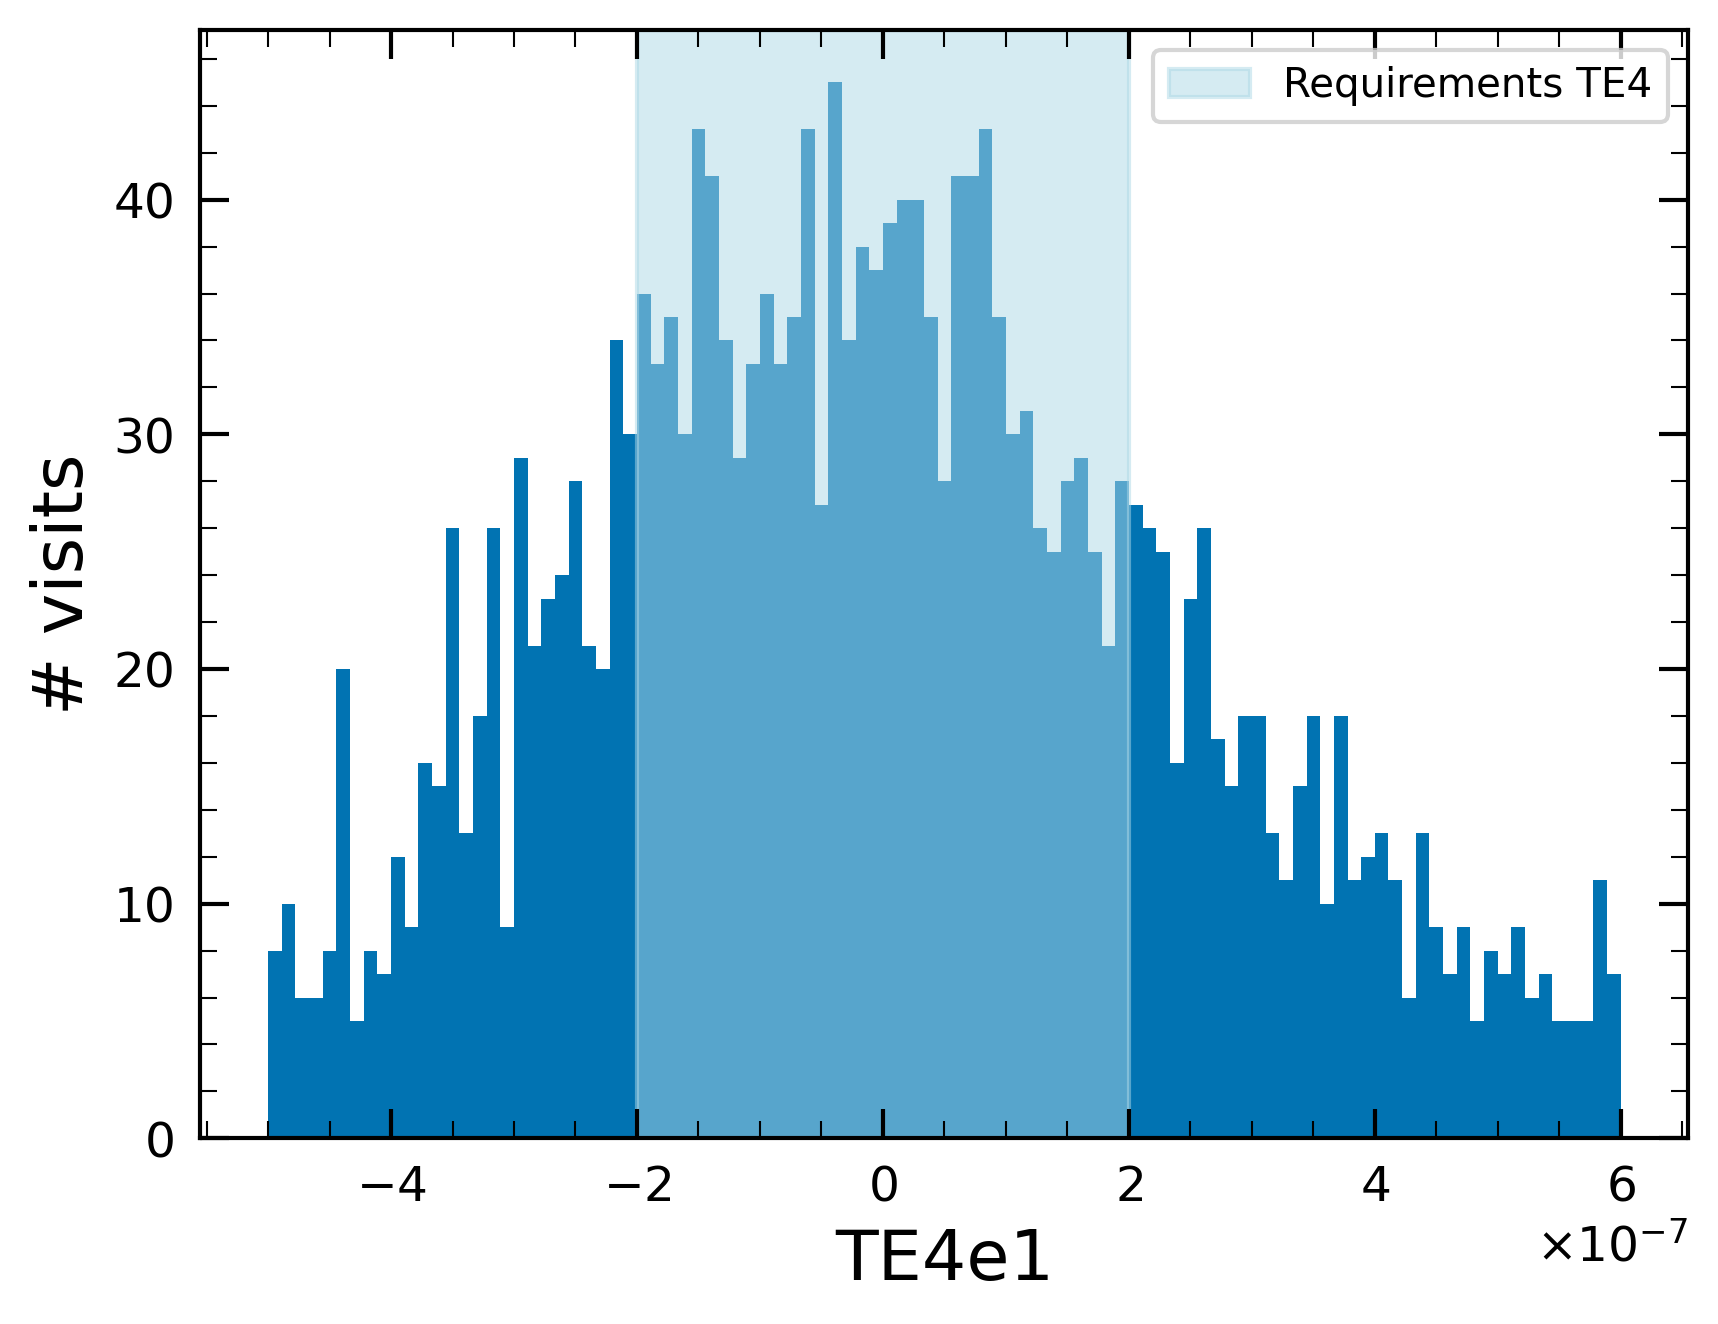

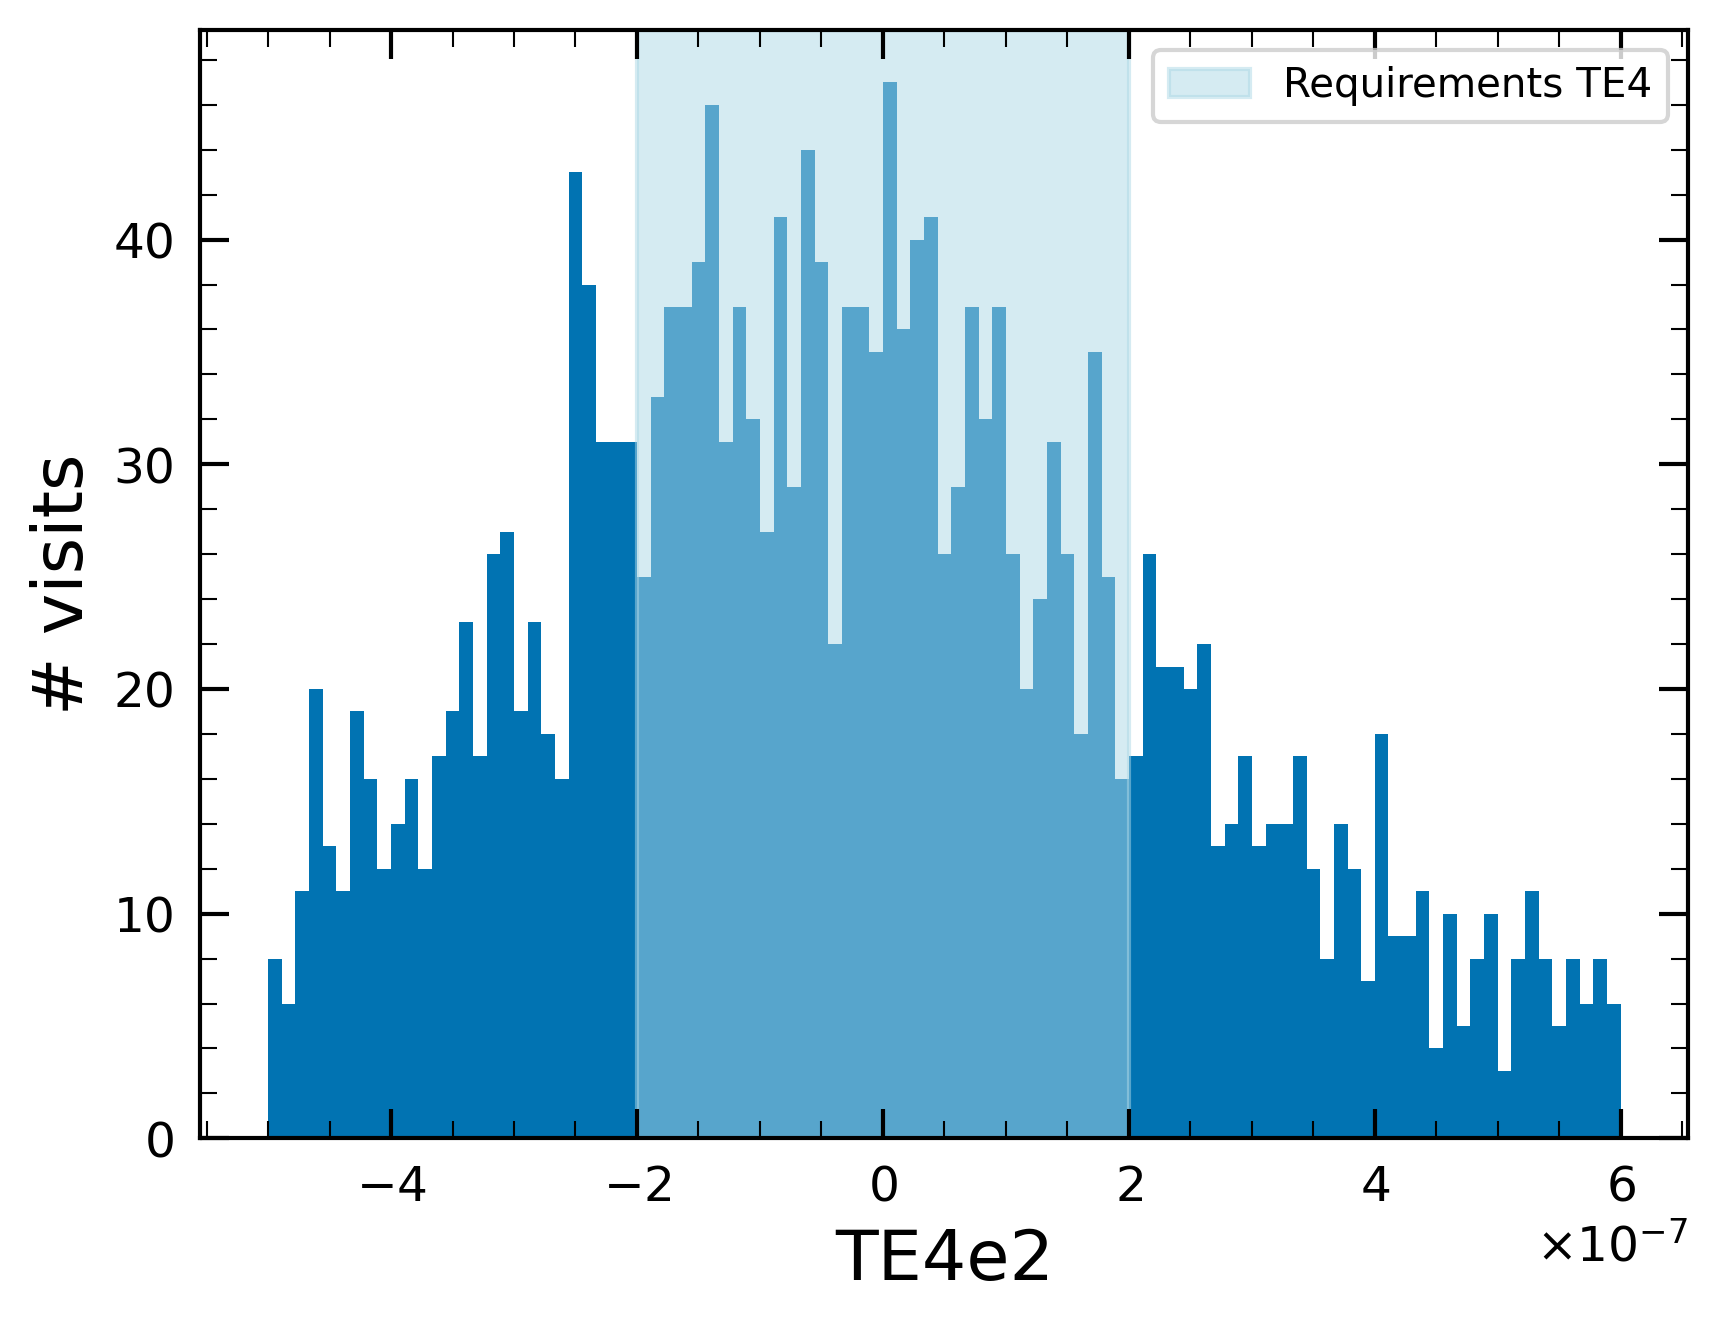

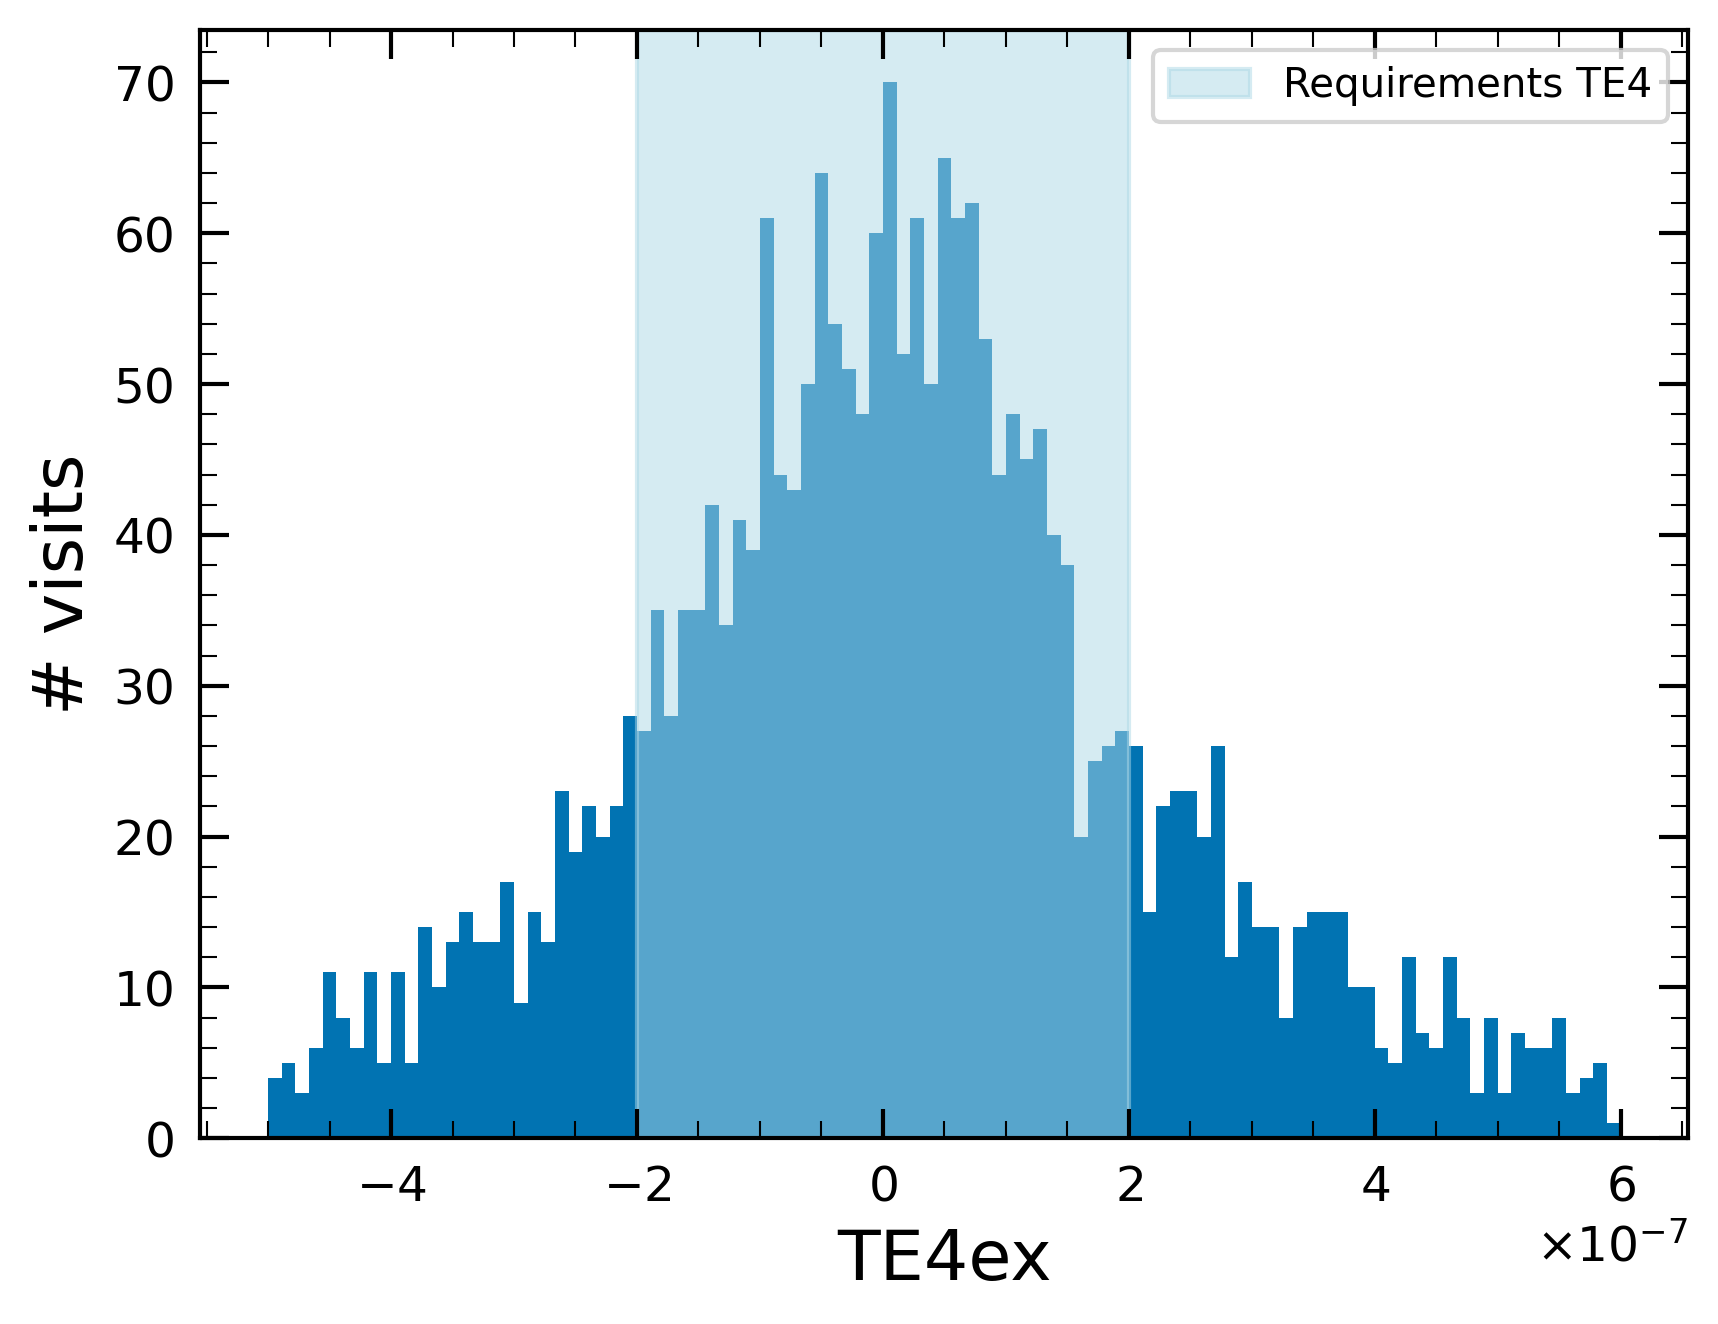

In [6]:
te4_requirement = 2e-7

for i in ['1', '2', 'x']:
    plt.figure()
    plt.hist(visitTable[f'psfTE4e{i}'], bins=np.linspace(-0.5e-6, 0.6e-6, 100))
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.xlabel(f"TE4e{i}")
    plt.ylabel("# visits")
    ylim = plt.ylim()
    plt.gca().fill_betweenx(ylim, -te4_requirement, te4_requirement, color='lightblue', alpha=0.5, label='Requirements TE4')
    medVal = np.nanmedian(visitTable[f'psfTE4e{i}'])
    plt.ylim(ylim)
    plt.legend()
    plt.show()


#### TEF for TE4:

TE4 is a threshold: the requirement is that the "Maximum fraction of visit images that may exceed the TE4 limit is TEF=15%." Check the percentage of images exceeding this TE4 threshold:

In [7]:
for i in ['1', '2', 'x']:
    print(f"\nMetric TE4e{i}")
    metrics_per_visit = visitTable[f'psfTE4e{i}']
    print(f"Percentage exceeding the TE4 threshold: {100.0*(np.sum(np.abs(metrics_per_visit) > te4_requirement)/len(metrics_per_visit)):7.3F} %")


Metric TE4e1
Percentage exceeding the TE4 threshold:  54.021 %

Metric TE4e2
Percentage exceeding the TE4 threshold:  55.994 %

Metric TE4ex
Percentage exceeding the TE4 threshold:  39.203 %


We see that the TE4 values are not meeting the requirement.

## Results

We have demonstrated that software tools exist to calculate residual ellipticity correlations, and that those quantities can be easily compiled for analysis. We see in the figures above that the median residual ellipticity correlation on scales less than 5 arcmin, TE3, meets the requirement that no more than TEF=15% of measurements are  beyond the required threshold for all three ellipticity quantities. The measured TE4 values do not meet the requirement. Nonetheless, because this requirement simply concerns the software to measure the ellipticity correlations, we deem the result of this test a **Pass**.